** It is recommended to create a virtual environment in the same folder (p.e: with the "venv" library) and install the libraries and their versions from the attached requirements.txt file.

<h1>Sentiment analysis during COP26

In [1]:
from IPython.core.display import display

import pandas as pd
pd.set_option('display.max_columns',100, 'display.max_colwidth',1000, 'display.max_rows',1000, 
              'display.float_format', lambda x: '%.2f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import html
import re
from datetime import datetime

#import sparknlp
from pyspark.sql import SparkSession, DataFrame
spark = SparkSession.builder \
    .master("local[4]")\
    .config("spark.driver.memory","8G")\
    .config("spark.driver.maxResultSize", "6G") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5")\
    .config("spark.kryoserializer.buffer.max", "1G")\
    .getOrCreate()

from sparknlp.pretrained import PretrainedPipeline

from pyspark.sql.functions import from_unixtime, unix_timestamp, to_date, year, size, udf, explode, split, col, length, rank, dense_rank, avg, array, row_number, expr, when, sum,lower, trim
from pyspark.sql import functions as f

from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, StopWordsRemover, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import StructType,StringType,IntegerType,StructField,TimestampType

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import functions as f
from pyspark.sql.window import Window

from pyspark.sql.streaming import DataStreamReader

import multiprocessing

import geopandas
import pycountry

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from wordcloud import WordCloud

import spacy

from textblob import TextBlob

22/03/30 10:18:13 WARN Utils: Your hostname, MacBook-Pro-de-Javier.local resolves to a loopback address: 127.0.0.1; using 192.168.121.162 instead (on interface en5)
22/03/30 10:18:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/javiermartinez/Documents/CIBIO/Proyectos/NLP/Tests/nlp_env/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/javiermartinez/.ivy2/cache
The jars for the packages stored in: /Users/javiermartinez/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3b70e704-9225-4393-9583-0529d826f371;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.11;2.4.5 in central
	found com.typesafe#config;1.3.0 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found org.apache.hadoop#hadoop-aws;3.2.0 in central
	found com.amazonaws#aws-java-sdk-core;1.11.603 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.9 in central
	found org.apache.httpcomponents#httpcore;4.4.11 in central
	found commons-codec#commons-codec;1.11 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazona

In [2]:
tweets = spark.read.json('./tweets-COP26-20220321.json').repartition(36).persist()

In [3]:
#Number of tweets
tweets.count()

1161645

 DataFrame fields

In [3]:
tweets.printSchema()

root
 |-- _type: string (nullable = true)
 |-- cashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- content: string (nullable = true)
 |-- conversationId: long (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- date: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- inReplyToTweetId: long (nullable = true)
 |-- inReplyToUser: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- created: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- descriptionUrls: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |  

In [3]:
tw_pt = (tweets
        .filter("lang = 'pt'")
        .withColumn('text',f.lower(f.col('content'))))

In [3]:
# Focus on the tweets that got at least 2 retweets, to try to take out bots and trash accounts
tw = (tweets
        .filter("lang = 'en'")
        .filter(f.col('retweetCount')>2)
        .withColumn('text',f.lower(f.col('content'))))

## Tweets by users 

In [19]:
from pyspark.sql.functions import regexp_replace, col,when
users = (
        tw 
        .select('user.displayname','user.followersCount','date') 
        .withColumn("user", trim(col("displayname")))
        )

In [6]:
### Delete emoticons and convert date to date format

# delete emoticons
@udf
def ascii_ignore(x):
    return x.encode('latin-1', 'ignore').decode('latin-1')


### There are some users with only spaces in their display names
def blank_as_null(x):
    return when(when(when(col(x) != "", col(x)) != " ",col(x)) != "  ", col(x)).otherwise(None)


users = (users
            .withColumn("user", ascii_ignore('displayname'))
            .withColumn("date", split(col("date"),"T").getItem(0))
            .withColumn('date',to_date("date", "yyyy-MM-dd"))
            .withColumn("user", blank_as_null("user") )
        )

NameError: name 'users' is not defined

In [165]:
### group by user 
u = (
    users
        .groupBy("user").count() 
        .withColumnRenamed("count","#tweets") 
        .filter("user != ''")
        .orderBy('count', ascending=False).limit(20).toPandas().reset_index(drop=True)
    )

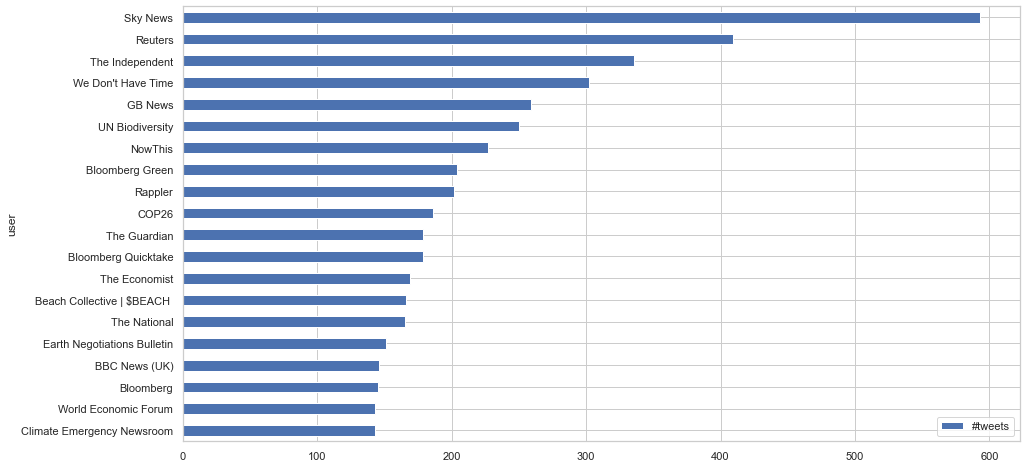

In [167]:
u.sort_values('#tweets', inplace=True)
u.plot.barh(x='user',y='#tweets', figsize=(15, 8));

### Tweets by User and Weekday

In [168]:
### group by (user, date)

u_wd = users.groupBy("user","date").count() \
        .orderBy('count', ascending=False).toPandas().reset_index(drop=True)

top20_users = u_wd.nlargest(20,'count')
top20_users['user'] = pd.Categorical(top20_users.user)

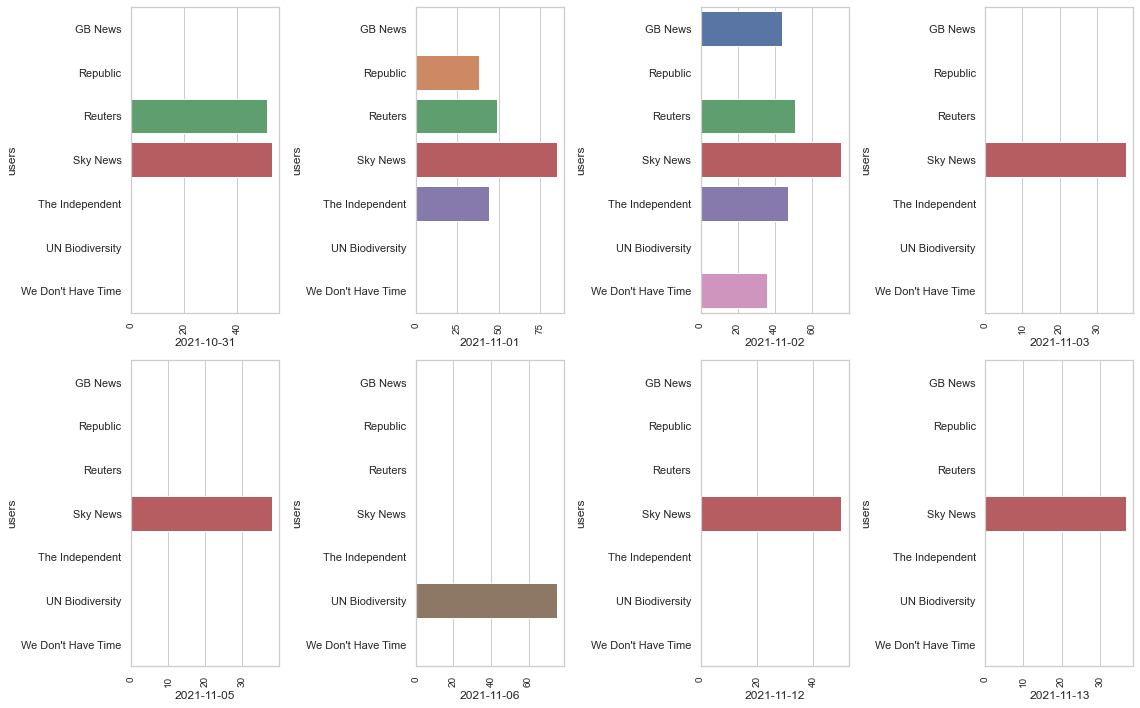

In [175]:
days = list(np.unique(top20_users.date))
plt.figure(figsize=(16,10))
sns.set(style="whitegrid")

for ax_num, day in zip(range(1,len(days)+1), days):
    plt.subplot(2,4,ax_num)
    sns.barplot(x='count', y='user',
                data=top20_users[top20_users['date'] == day])
    plt.xticks(rotation=90, fontsize=10)
    plt.xlabel(day)
    plt.ylabel("users")
    
    
plt.tight_layout()

###### The most prolific users sent their tweets in October 31st and November 1, 2, 3, 5, 6, 12 and 13th. Probably the days with the most significant speeches.

## Tweets by influencers


In [4]:
influencers = (tw      
    .select('user.displayName','user.followersCount')
    .groupBy('displayName')
    .agg(f.max('followersCount'),f.count('displayName'))
    .orderBy('max(followersCount)', ascending=False)
    .withColumnRenamed('max(followersCount)','followers')
    .withColumnRenamed('count(displayName)','#tweets')
    .withColumnRenamed('displayName','influencer')
              )

###### Top 10 most influential users

In [5]:
influencers.limit(10).toPandas()

,influencer,followers,#tweets
0,Barack Obama,131338598,2
1,Narendra Modi,77138930,7
2,YouTube,74679635,1
3,CNN Breaking News,62660810,4
4,Bill Gates,57648064,6
5,CNN,57207692,51
6,NASA,54568812,1
7,The New York Times,52342810,60
8,BBC Breaking News,49561814,10
9,PMO India,47551809,4


In [6]:
## filter out users with less followers count than the 65th quantile
follower_limit = influencers.select(f.percentile_approx("followers", 0.65)).rdd.flatMap(lambda x: x).collect()

influencers = influencers.filter(f.col('followers')>=follower_limit[0])

influencer_list = influencers.select("influencer").rdd.flatMap(lambda x: x).collect()

#filter out tweets from influencers
inf_tw = tw.filter(f.col('user.displayName').isin(influencer_list)).cache()

In [7]:
### group by user 
inf = (
    inf_tw
        .groupBy("user.displayName").count()
        .withColumnRenamed("count","#tweets")
        .withColumnRenamed("displayName","influencer")
        .orderBy('count', ascending=False).limit(20).toPandas().reset_index(drop=True))

In [8]:
inf.head()

,influencer,#tweets
0,Sky News,593
1,Reuters,409
2,The Independent,336
3,We Don't Have Time,302
4,GB News,259


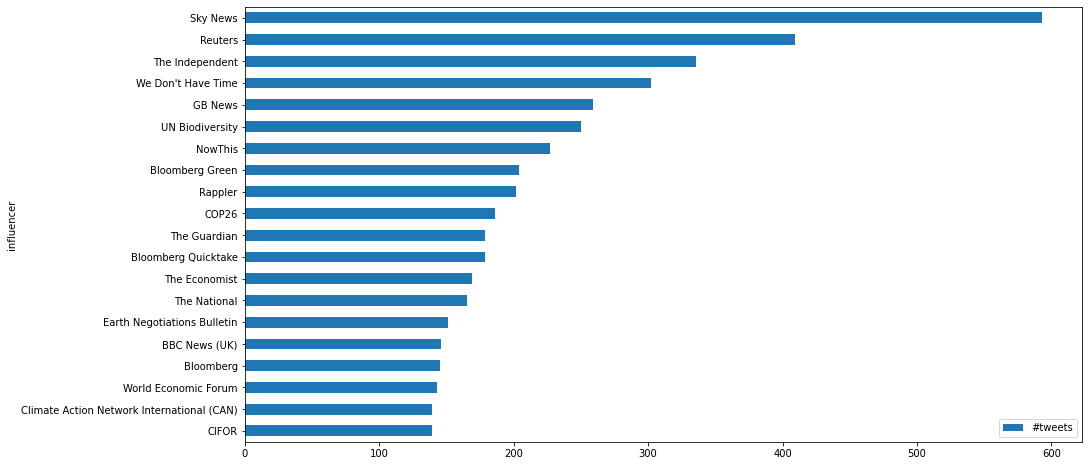

In [9]:
inf.sort_values('#tweets', inplace=True)
inf.plot.barh(x='influencer',y='#tweets', figsize=(15, 8));

### Tweets by Influencer and Weekday

In [22]:
### group by (influencer, date)

inf_wd = (
        inf_tw 
            .select('user.displayname','user.followersCount','date') 
            .withColumn("user", trim(col("displayname")))
            )


inf_wd = (
        inf_wd
            .withColumn("user", ascii_ignore('displayname'))
            .withColumn("date", split(col("date"),"T").getItem(0))
            .withColumn('date',to_date("date", "yyyy-MM-dd"))
            .withColumn("user", blank_as_null("user") )
        )


inf_wd = (
        inf_wd
            .groupBy("user","date").count() 
            .orderBy('count', ascending=False).toPandas().reset_index(drop=True))

top20_influencers = inf_wd.nlargest(20,'count')
top20_influencers['user'] = pd.Categorical(top20_influencers.user)

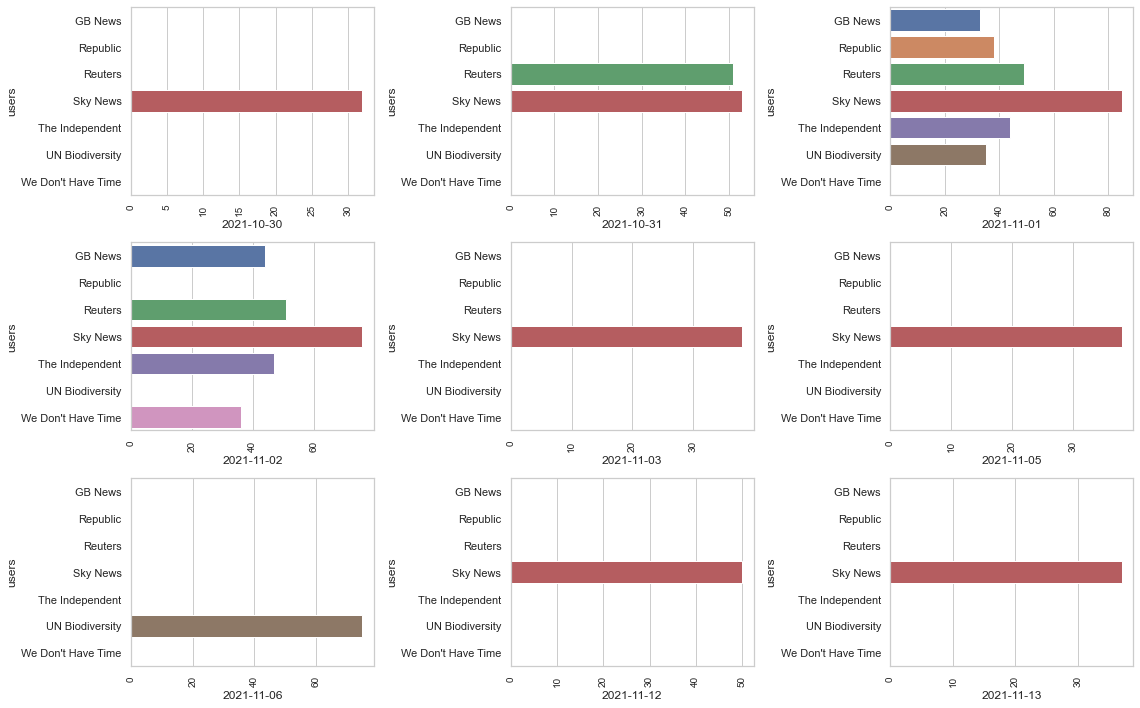

In [25]:
days = list(np.unique(top20_influencers.date))
plt.figure(figsize=(16,10))
sns.set(style="whitegrid")

for ax_num, day in zip(range(1,len(days)+1), days):
    plt.subplot(3,3,ax_num)
    sns.barplot(x='count', y='user',
                data=top20_influencers[top20_influencers['date'] == day])
    plt.xticks(rotation=90, fontsize=10)
    plt.xlabel(day)
    plt.ylabel("users")
    
    
plt.tight_layout()

## Hashtags most used

In [4]:
hashtags = (
    tw_pt
    .where(col('hashtags').isNotNull())
    .withColumn("hashtags", explode("hashtags"))
    .select(lower(col('hashtags')).alias('hashtags'),'date') 
)

In [190]:
hashtags = (
    tw
    .where(col('hashtags').isNotNull())
    .withColumn("hashtags", explode("hashtags"))
    .select(lower(col('hashtags')).alias('hashtags'),'date') 
)

In [7]:
### Delete emoticons and convert date to date format

@udf
def ascii_ignore(x):
    return x.encode('latin-1', 'ignore').decode('latin-1')


hashtags = (
        hashtags
            .withColumn("hashtags", ascii_ignore('hashtags'))
            .withColumn("date", split(col("date"),"T").getItem(0))
            .withColumn('date',to_date("date", "yyyy-MM-dd"))
        )

In [8]:
### group by user 
h = (
    hashtags
        .groupBy("hashtags").count() 
        .withColumnRenamed("count","#ocurrences") 
        .orderBy('count', ascending=False).limit(20).toPandas().reset_index(drop=True)
    )

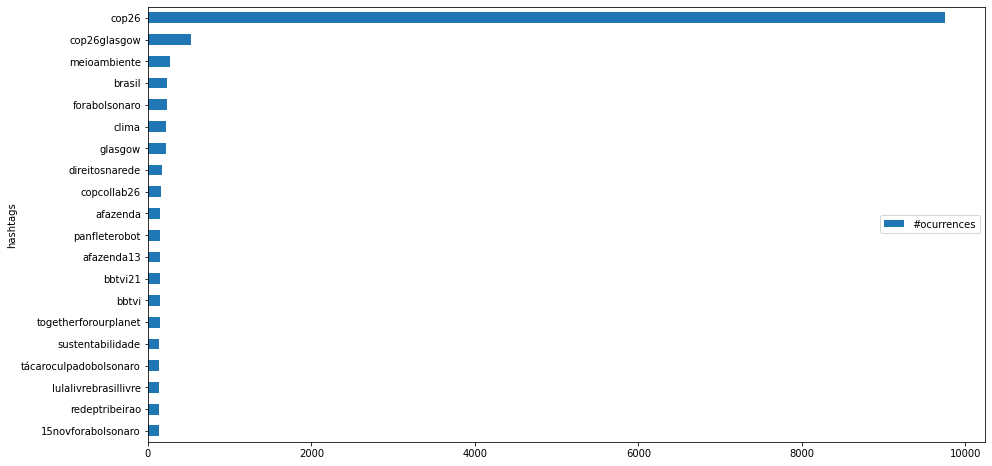

In [9]:
h.sort_values('#ocurrences', inplace=True)
h.plot.barh(x='hashtags',y='#ocurrences', figsize=(15, 8)).legend(loc='right');

### Hashtags by Weekday

In [203]:
### group by (hashtags, date)

h_wd = (
        hashtags
            .groupBy("hashtags","date").count() 
            .orderBy('count', ascending=False).toPandas().reset_index(drop=True)
        )

top20_hashtags = h_wd.nlargest(20,'count')
top20_hashtags['hashtags'] = pd.Categorical(top20_hashtags.hashtags)

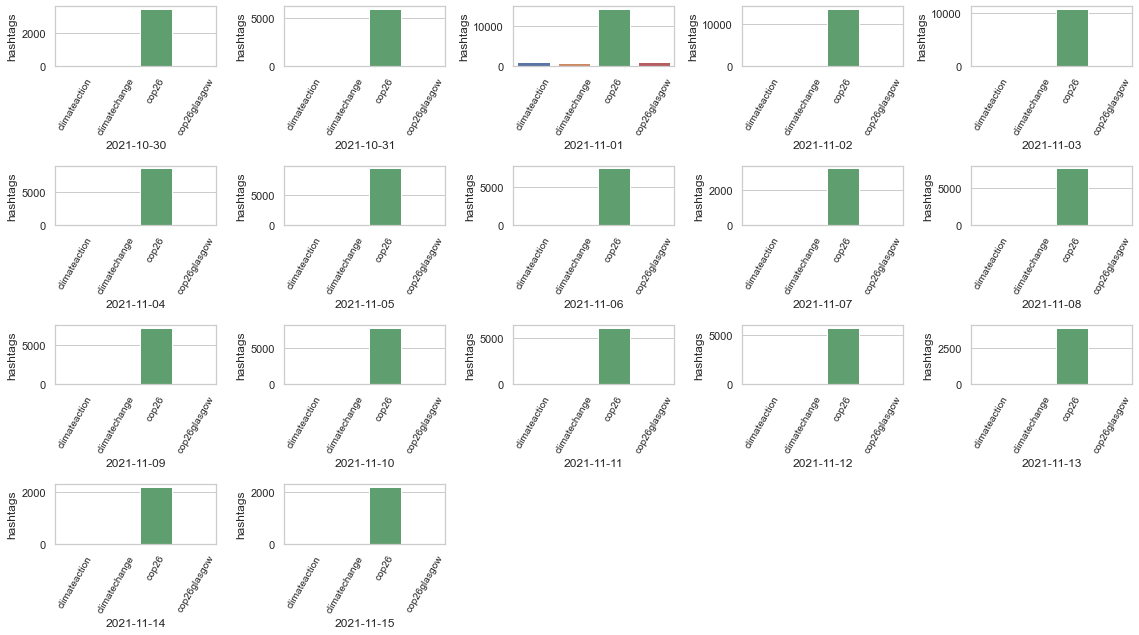

In [211]:
days = list(np.unique(top20_hashtags.date))
plt.figure(figsize=(16,9))
sns.set(style="whitegrid")

for ax_num, day in zip(range(1,len(days)+1), days):
    plt.subplot(4,5,ax_num)
    sns.barplot(x='hashtags', y='count',
                data=top20_hashtags[top20_hashtags['date'] == day])
    plt.xticks(rotation=60, fontsize=10)
    plt.xlabel(day)
    plt.ylabel("hashtags")
    
plt.tight_layout()

## Most Mentioned Users

In [212]:
m_users = (
        tw
        .where(col("mentionedUsers").isNotNull())
        .withColumn("mentionedUsers", explode("mentionedUsers"))
        .withColumn("date", split(col("date"),"T").getItem(0))
        .withColumn("date",to_date("date", "yyyy-MM-dd"))
        .select(lower(col('mentionedUsers.displayname')).alias('mentionedUsers'),'date')
        .withColumn("mentionedUsers", ascii_ignore(col("mentionedUsers")))
)

In [215]:
### Number of tweets by mentioned User 
m_u = (
        m_users
            .groupBy("mentionedUsers").count() 
            .withColumnRenamed("count","#ocurrences")
            .orderBy('count', ascending=False).limit(20).toPandas().reset_index(drop=True)
      )

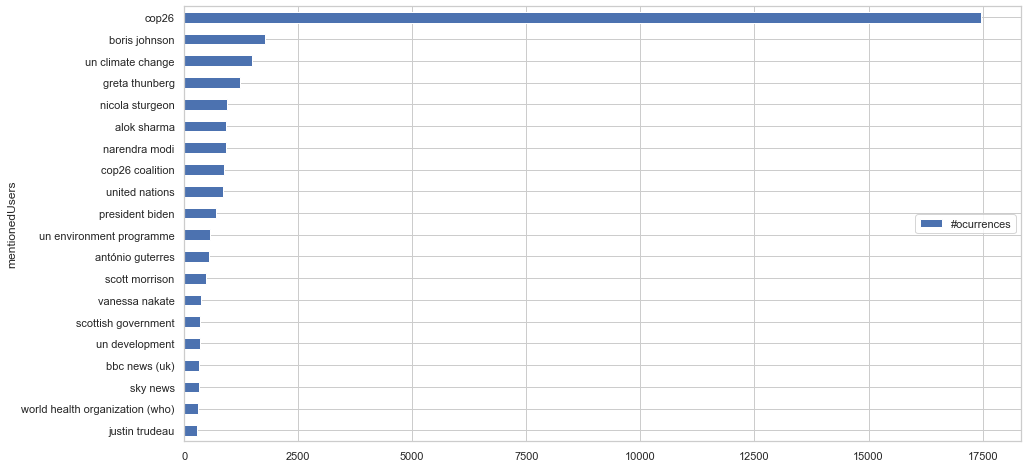

In [216]:
m_u.sort_values('#ocurrences', inplace=True)
m_u.plot.barh(x='mentionedUsers',y='#ocurrences', figsize=(15, 8)).legend(loc='right');

In [217]:
### group by (mentioned_user, date)

m_u_wd = (
        m_users
            .groupBy("mentionedUsers","date").count() 
            .orderBy('count', ascending=False)
            .toPandas()
            .reset_index(drop=True)
        )

top20_mentioned = m_u_wd.nlargest(20,'count')
top20_mentioned['mentionedUsers'] = pd.Categorical(top20_mentioned.mentionedUsers)

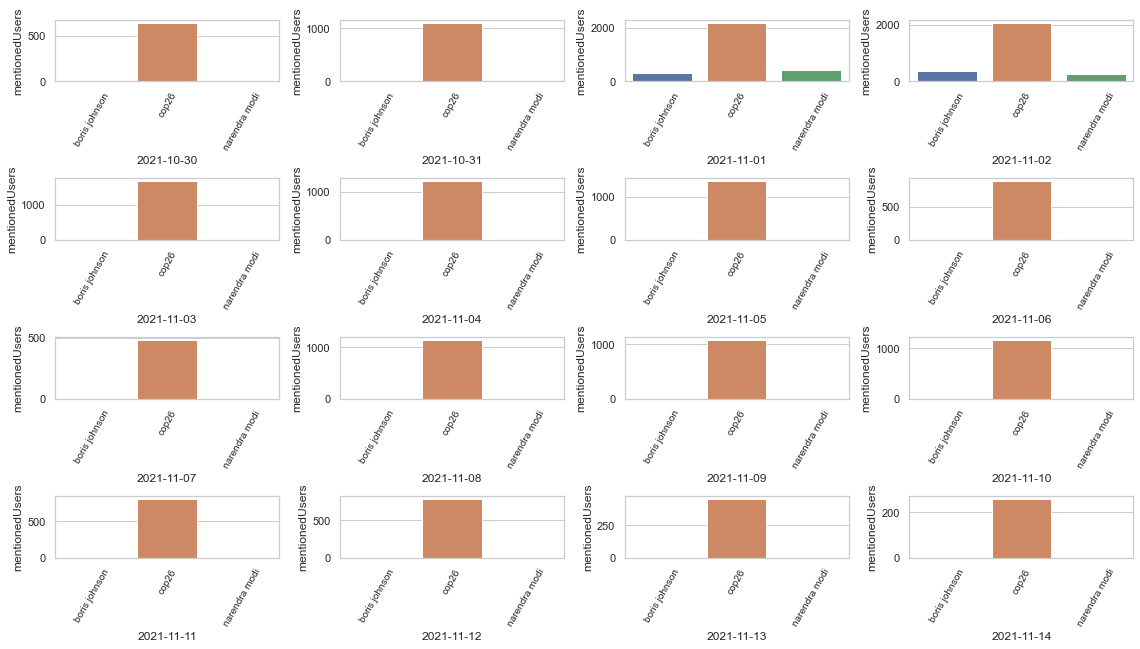

In [222]:
days = list(np.unique(top20_mentioned.date))
plt.figure(figsize=(16,9))
sns.set(style="whitegrid")

for ax_num, day in zip(range(1,len(days)+1), days):
    plt.subplot(4,4,ax_num)
    sns.barplot(x='mentionedUsers', y='count',
                data=top20_mentioned[top20_mentioned['date'] == day])
    plt.xticks(rotation=60, fontsize=10)
    plt.xlabel(day)
    plt.ylabel("mentionedUsers")
    
plt.tight_layout()

## Tweets count by Country

In [224]:
@udf
def html_unescape(s: str):
    return html.unescape(s)


location = (
        tw
        .select(col('place.country').alias('country'),'date')
        .where(col("country")!= "''")
        .withColumn("date", split(col("date"),"T").getItem(0))
        .withColumn("date",to_date("date", "yyyy-MM-dd"))
        # Unescape any HTML
        .withColumn("country", html_unescape(f.col("country")))
        
        # Remove all numbers, double/multiple spaces, and leading/trailing whitespaces
        .withColumn("country", f.regexp_replace(f.col("country"), "[^a-zA-Z']", " "))
        .withColumn("country", f.regexp_replace(f.col("country"), " +", " "))
        .withColumn("country", f.trim(f.col("country")))
        
        # Ensure we don't end up with empty rows
        .filter(f.col("country") != "").na.drop(subset="country")
)


In [228]:
### group by country 
l = (
    location
        .groupBy("country")
        .count() 
        .withColumnRenamed("count","#tweets")
        .orderBy('count', ascending=False).limit(20).toPandas().reset_index(drop=True)
    )

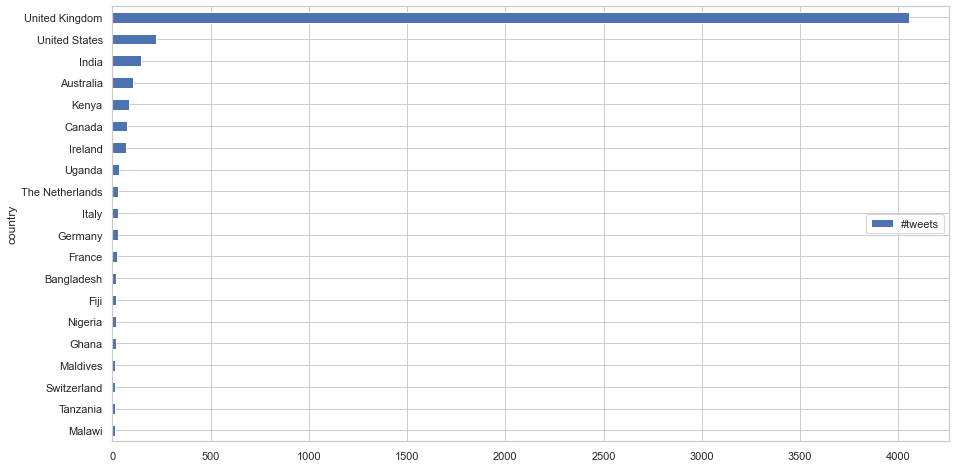

In [230]:
l.sort_values('#tweets', inplace=True)
l.plot.barh(x='country',y='#tweets', figsize=(15, 8)).legend(loc='right');

## Sentiment Analysis

### Model

In [236]:
@udf
def html_unescape(s: str):
    if isinstance(s, str):
        return html.unescape(s)
    return s


def clean_data(df: DataFrame):
    url_regex = r"((https?|ftp|file):\/{2,3})+([-\w+&@#/%=~|$?!:,.]*)|(www.)+([-\w+&@#/%=~|$?!:,.]*)"
    email_regex = r"[\w.-]+@[\w.-]+\.[a-zA-Z]{1,}"
    user_regex = r"(@\w{1,15})"
    
    return (
        df
        
        # Store the original text column in a new column for future reference
        .withColumn("original_text", f.col("text"))
        
        # Remove email addresses, URLs, and user mentions
        .withColumn("text", f.regexp_replace(f.col("text"), url_regex, ""))
        .withColumn("text", f.regexp_replace(f.col("text"), email_regex, ""))
        .withColumn("text", f.regexp_replace(f.col("text"), user_regex, ""))
        .withColumn("text", f.regexp_replace(f.col("text"), "#", " "))
        
        # Unescape any HTML
        .withColumn("text", html_unescape(f.col("text")))
        
        # Remove all numbers, double/multiple spaces, and leading/trailing whitespaces
        .withColumn("text", f.regexp_replace(f.col("text"), "[^a-zA-Z']", " "))
        .withColumn("text", f.regexp_replace(f.col("text"), " +", " "))
        .withColumn("text", f.trim(f.col("text")))
        
        # Ensure we don't end up with empty rows
        .filter(f.col("text") != "").na.drop(subset="text")
    )

###### From here on it is not necessary run the cell because the model is already created and attached to the email

######  **********

###### Pipeline creation for tweet content processing and modeling. The final model is already trained. This code is for improvement purposes.

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words1")
stopwords_remover = StopWordsRemover(
    inputCol="words1",
    outputCol="words2",
    stopWords=StopWordsRemover.loadDefaultStopWords("english")
)

#ngrams = NGram(
#    n=3,
#    inputCol="words2",
#    outputCol="words3")

hashing_tf = HashingTF(
    inputCol="words2",
    outputCol="term_frequency",
)
idf = IDF(
    inputCol="term_frequency",
    outputCol="features",
    minDocFreq=5,
)
lr = LogisticRegression(labelCol="polarity")
#rf = RandomForestClassifier(featuresCol='features',labelCol="polarity")

semantic_analysis_pipeline = Pipeline(
    stages=[tokenizer, stopwords_remover, ngrams, hashing_tf, idf, lr]
)

###### The data used for training the model was downloaded from http://help.sentiment140.com/for-students

In [ ]:
schema = "polarity FLOAT, id LONG, date_time TIMESTAMP, query STRING, user STRING, text STRING"
timestampformat = "EEE MMM dd HH:mm:ss zzz yyyy"


OUT_PATH = "./trainingandtestdata/data" ### Here you can insert the path that you prefer

# load training.1600000.processed.noemoticon.csv
TRAININGDATA_PATH = "./trainingandtestdata/training.1600000.processed.noemoticon.csv"
spark_reader = spark.read.schema(schema)


data = spark_reader.csv(
    TRAININGDATA_PATH,
    quote='"',
    header=False,
    #inferSchema=True,
    columnNameOfCorruptRecord="corrupt_data",
).cache()

In [ ]:
data_in = clean_data(data)

data_model = data_in.select("text", "polarity").coalesce(3).cache()

(training_data, validation_data, test_data) = data_model.randomSplit([0.98, 0.01, 0.01], seed=2022)

In [ ]:
semantic_analysis_model = semantic_analysis_pipeline.fit(training_data)

trained_df = semantic_analysis_model.transform(training_data)
val_df = semantic_analysis_model.transform(validation_data)
test_df = semantic_analysis_model.transform(test_data)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="polarity", metricName="accuracy")

accuracy_val = evaluator.evaluate(val_df)
accuracy_test = evaluator.evaluate(test_df)
print("Validation Data:")
print(f"Accuracy: {accuracy_val*100:.5f}%")
print("Testing Data:")
print(f"Accuracy: {accuracy_test*100:.5f}%")

In [ ]:
final_model = semantic_analysis_pipeline.fit(data_model)

accuracy_test = evaluator.evaluate(final_model.transform(test_data))
print(f"Accuracy: {accuracy_test*100:.5f}%")

In [ ]:
final_model.write().overwrite().save(OUT_PATH)

######  ******************************************************

###### End of the model creation

### Reload pre-trained model

In [235]:
OUT_PATH = "./trainingandtestdata/data"

sentiment_model = PipelineModel.load(OUT_PATH)

In [237]:
## Processing the content of the tweets. 'tw' is the filtered dataframe by lang='en' and retweets>2
clean_content = clean_data(tw)

raw_sentiment = sentiment_model.transform(clean_content)

In [238]:
sentiment = (raw_sentiment
             .select("original_text","text", f.col("prediction").alias("user_sentiment"), "place.country")
             .filter(f.col("country")!='')
             .withColumn("user_sentiment", f.when((f.col("user_sentiment") == 0.0), f.lit("Negative"))
             .otherwise( f.lit("Positive"))))       
display(sentiment.limit(10).toPandas())

22/03/23 09:34:10 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


,original_text,text,user_sentiment,country
0,"as we await the full financial cost of cop26. which was, i would suggest, a total expensive bore. @borisjohnson ‘s doom and gloom forecast will prove to be a total nonsense.\n\nq. with the phasing out of coal. does that mean the end of steel production in the uk? we need to know.",as we await the full financial cost of cop which was i would suggest a total expensive bore s doom and gloom forecast will prove to be a total nonsense q with the phasing out of coal does that mean the end of steel production in the uk we need to know,Negative,United Kingdom
1,"summing up #cop26 ""pretend and procrastinate""",summing up cop pretend and procrastinate,Positive,Spain
2,"i am proud that my region, wallonia, contributed 1 million euros for loss and damage due to climate change, following the lead by scotland and my earlier suggestion. thank you ministers @phh_henry and @cruckejeanluc! #cop26 https://t.co/y8wxc2nbnf",i am proud that my region wallonia contributed million euros for loss and damage due to climate change following the lead by scotland and my earlier suggestion thank you ministers and cop,Positive,United Kingdom
3,"hugely disappointing that the agreement reached at #cop26 has failed to deliver anywhere near enough action on #climate change, that the most vulnerable countries not heard enough and fossil fuel wording weakened at last minute. far too much #blahblahblah",hugely disappointing that the agreement reached at cop has failed to deliver anywhere near enough action on climate change that the most vulnerable countries not heard enough and fossil fuel wording weakened at last minute far too much blahblahblah,Negative,United Kingdom
4,yesterday was youth takeover day at #cop26 and we had the pleasure to host kalyani ramanan at our @esa booth☺️\nkalyani is a young graduate trainee at @esaclimate - she researches the impact of wildfires on lake ecosystems. https://t.co/gvdzexmis7,yesterday was youth takeover day at cop and we had the pleasure to host kalyani ramanan at our booth kalyani is a young graduate trainee at she researches the impact of wildfires on lake ecosystems,Positive,Italy
5,"as we're going into overtime with #cop26 and decision makers at gridlock, i am more and more convinced it's young people and activism that will save us!\n\n🗣️📣amazing experience marching through cop in protest after the people's plenary ✊🏻\n\n#peoplearethepower https://t.co/60brzq4gnz",as we're going into overtime with cop and decision makers at gridlock i am more and more convinced it's young people and activism that will save us amazing experience marching through cop in protest after the people's plenary peoplearethepower,Positive,United Kingdom
6,the new text on saturday on #glasgowlossanddamagefacility is worse than the text on friday! what happened @aloksharma_rdg ? who nobbled you overnight? what you have given today means @cop26 will be worse than copenhagen! https://t.co/bhgyftdils,the new text on saturday on glasgowlossanddamagefacility is worse than the text on friday what happened who nobbled you overnight what you have given today means will be worse than copenhagen,Negative,United Kingdom
7,"big we of the climate movement: well done, and yet so much more to do at speed. sleep well everyone and get ready for monday: another day in the fight of our lives #cop26 #climateemergency",big we of the climate movement well done and yet so much more to do at speed sleep well everyone and get ready for monday another day in the fight of our lives cop climateemergency,Positive,United Kingdom
8,"#cop26 agrees to change ""phase-down"" from ""phase-out"" use of coal following a last minute verbal amendment from #india during the approval plenary session. this is a travesty and a significant weakening of ambition that the world cannot afford #climatecrisis #climateaction",cop agrees to change phase down from phase out use of coal following a last minute verbal amendment from india during the appro

###### It is difficult to distinguish sarcasm for the model 

#### Total Sentiment Frequency 

22/03/23 09:39:17 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 09:39:21 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 09:39:21 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 09:39:22 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


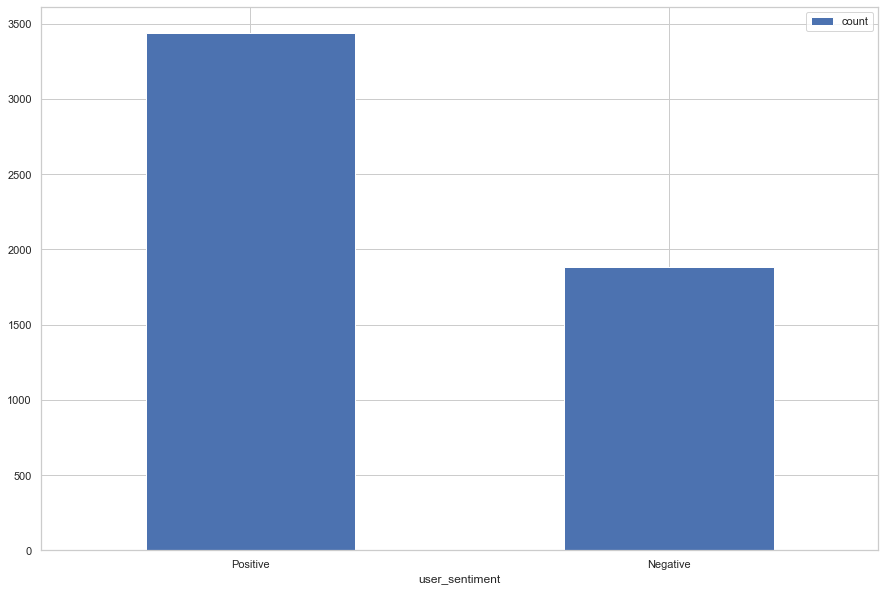

In [240]:
(sentiment
    .groupBy("user_sentiment").count()
    .orderBy('count', ascending=False)
    .toPandas()
    .reset_index(drop=True)
    .plot.bar(x='user_sentiment',y='count',rot=0, figsize=(15, 10)));

#### Sentiment by Country

###### Firstly calculate a sentiment ratio in order to get the colour palette for the map

In [244]:
a = (sentiment
    .select('country','user_sentiment')
    .groupBy('country','user_sentiment')
    .count()
    .orderBy('country')
    .toPandas())


b = (sentiment
    .select('country','user_sentiment')
    .groupBy('country')
    .count()
    .orderBy('country')
    .toPandas())


DF = pd.merge(a, b, on=['country'])
DF['ratio'] = DF['count_x']/DF['count_y']
DF = DF.drop_duplicates(subset=['country'])
DF['ratio_positive'] = np.where(DF['user_sentiment']== 'Positive', DF['ratio'], 1 - DF['ratio'])
DF = DF[['country','ratio_positive']].reset_index(drop=True)

### Fill NAs with '' and 0.5 ratio_positive values
DF_merge = DF_merge.fillna({'ratio_positive': 0.5, 'country': ''})

22/03/23 09:47:13 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 09:47:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 09:47:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 09:47:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


,country,ratio_positive
0,Albania,1.00
1,Antigua and Barbuda,0.00
2,Armenia,0.00
3,Aruba,0.00
4,Australia,0.58
5,Austria,0.60
6,Bahamas,0.25
7,Bangladesh,0.35
8,Barbados,0.00
9,Belgium,0.73


###### Load country codes from pycountry package

In [257]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3
    
DF['country_codes'] = [countries.get(country, 'Unknown code') for country in DF.country]

In [258]:
### Some countries must be modified manually in order to properly indentify them
DF.loc[DF['country']=='Brunei','country_codes'] = 'BRN'
DF.loc[DF['country']=='Islamic Republic of Iran','country_codes'] = 'IRN'
DF.loc[DF['country']=='Kingdom of Saudi Arabia','country_codes'] = 'SAU'
DF.loc[DF['country']=="People's Republic of China",'country_codes'] = 'CHN'
DF.loc[DF['country']=='Republic of the Philippines','country_codes'] = 'PHL'
DF.loc[DF['country']=='Tanzania','country_codes'] = 'TZA'
DF.loc[DF['country']=='The Netherlands','country_codes'] = 'NLD'

In [259]:
### Just checking
DF.loc[DF['country_codes']=='Unknown code']

,country,ratio_positive,iso_a3,country_codes
11,Bolivia,0.00,Unknown code,Unknown code
21,Czech Republic,1.00,Unknown code,Unknown code
22,Democratic Republic of Congo,1.00,Unknown code,Unknown code
34,Hashemite Kingdom of Jordan,0.00,Unknown code,Unknown code
69,Republic of Korea,1.00,Unknown code,Unknown code
70,Republic of Mauritius,0.00,Unknown code,Unknown code
71,Republic of Serbia,1.00,Unknown code,Unknown code
72,Republic of Slovenia,1.00,Unknown code,Unknown code
77,Slovak Republic,1.00,Unknown code,Unknown code
85,Taiwan,0.33,Unknown code,Unknown code


In [254]:
### Preparing rest of the values for the map
DF['iso_a3'] = DF['country_codes']

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

DF.drop('country_codes',axis=1,inplace=True)
DF_merge = pd.merge(world,DF,how='left',on="iso_a3")

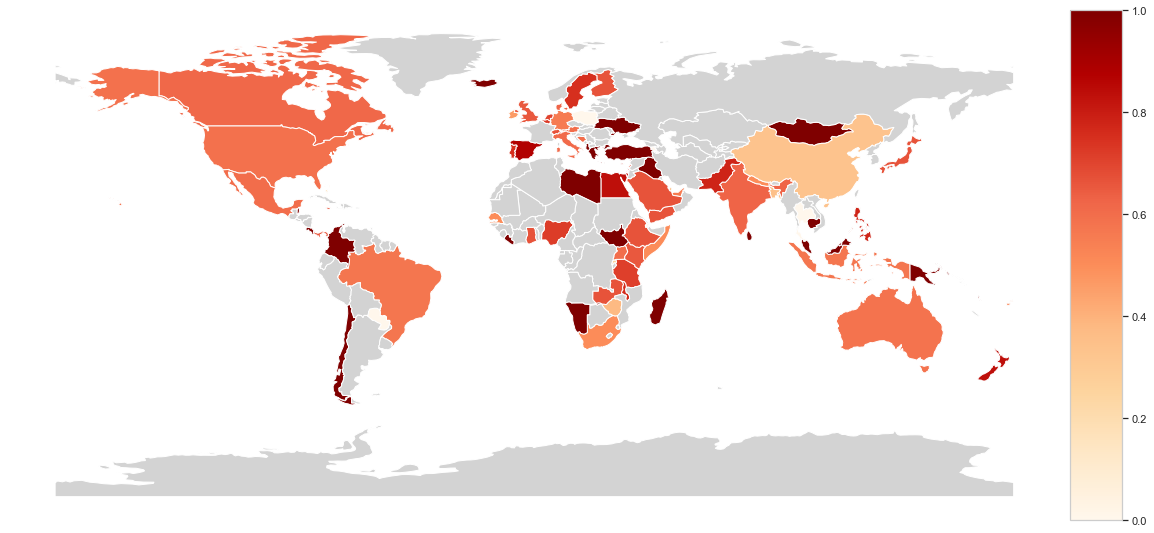

In [255]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(20,15))
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)


DF_merge.plot(column='ratio_positive', 
              ax=ax, 
              cax=cax,
              legend=True,cmap='OrRd', 
              #scheme='quantiles',
              missing_kwds={'color': 'lightgrey'},
              
);
ax.axis('off');

###### More red more positive

#### Sentiment Timeline

In [260]:
sentiment_timeline = (raw_sentiment
                     .select("date", f.col("prediction").alias("user_sentiment"))
                     .withColumn("date", split(col("date"),"T").getItem(0))
                     .withColumn("date",to_date("date", "yyyy-MM-dd"))
                     .withColumn("user_sentiment", f.when((f.col("user_sentiment") == 0.0), f.lit("Negative"))
                     .otherwise( f.lit("Positive"))))

22/03/23 10:36:22 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 10:37:42 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 10:37:43 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 10:37:43 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 10:38:54 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 10:38:54 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 10:38:55 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/03/23 10:38:55 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


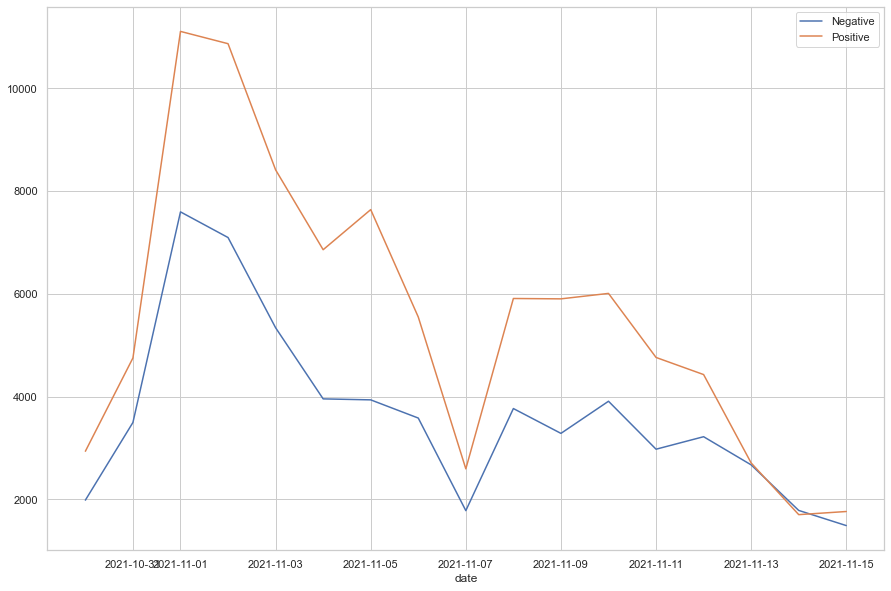

In [261]:
st = (sentiment_timeline
         .groupBy('date')
         .pivot("user_sentiment")
         .count()
         .orderBy(["date"])
         .toPandas()
)


final_df = st.set_index('date')
final_df[['Negative', 'Positive']].plot(figsize=(15,10))
plt.show()

In [26]:
## Clean memory cache()
spark.catalog.clearCache()